In [1]:
import fitsio as ft
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('/users/PHS0336/medirz90/github/LSSutils')
from lssutils.utils import make_hp
from lssutils.lab import get_cl
from lssutils.extrn.galactic.hpmaps import logHI
from sklearn.linear_model import LinearRegression
from lssutils.dataviz import setup_color

In [2]:
setup_color()

In [3]:
def run_linear(xtrain, ytrain,
              xtest, ytest, 
              x, ix):
    
    reg2 = LinearRegression().fit(xtrain, ytrain)
    npred = reg2.predict(xtest)
    print(f'MSE: {((npred - ytest)**2).mean():.3f} MAE:{(abs(npred - ytest)).mean():.3f}')
    
    sfun = reg2.predict(x)
    return make_hp(1024, ix, sfun, True) / sfun.mean()

In [4]:
lh = logHI(nside_out=1024, path='/fs/ess/PHS0336/data/templates/NHI_HPX.fits')

/users/PHS0336/medirz90/github/LSSutils/lssutils/extrn/galactic/hpmaps.py:96: RuntimeWarning: invalid value encountered in log10
  self.map    = np.log10(nhi_c)


In [8]:
df = ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v3/nelg_features_bmzls_1024.fits')
loghi = lh.map[:, np.newaxis]
hi = 10**(loghi-20.)

ix = df['hpix']
frac = make_hp(1024, df['hpix'], df['fracgood'], True)
mask = np.isfinite(frac)
ngal = make_hp(1024, df['hpix'], df['label'], True)

print(mask.sum())
x1 = loghi #np.column_stack([loghi, loghi*loghi])
x2 = hi    #np.column_stack([hi, hi*hi])

np.random.seed(85)
train_ix = np.random.choice(ix, size=int(0.8*ix.size), replace=False)
test_ix = np.setdiff1d(ix, train_ix)

1552540


In [9]:
sf_loghi = run_linear(x1[train_ix], ngal[train_ix],
                      x1[test_ix], ngal[test_ix],
                      x1[ix], ix)
sf_loghi *= (ngal[ix]/sf_loghi[ix]).sum() / ngal[ix].sum()

MSE: 9.753 MAE:2.466


In [10]:
sf_hi = run_linear(x2[train_ix], ngal[train_ix],
                   x2[test_ix], ngal[test_ix],
                   x1[ix], ix)
sf_hi *= (ngal[ix]/sf_hi[ix]).sum() / ngal[ix].sum()

MSE: 9.770 MAE:2.472


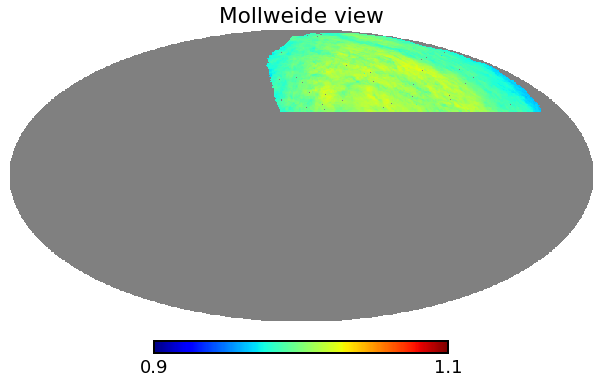

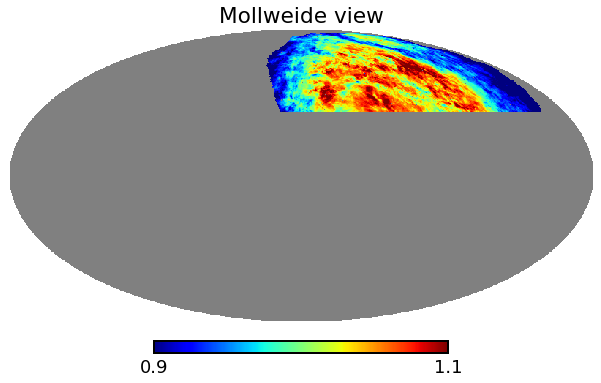

In [13]:
kw = dict(min=0.9, max=1.1, rot=-95, cmap=plt.cm.jet)
hp.mollview(sf_hi, **kw)
hp.mollview(sf_loghi, **kw)

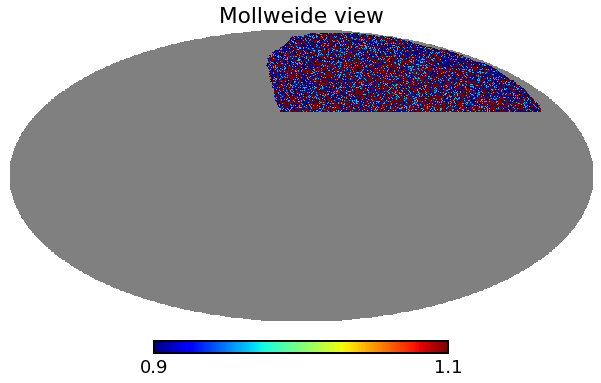

In [14]:
hp.mollview(ngal/df['label'].mean(), **kw)

In [15]:
cl_null = get_cl(ngal, frac, mask, njack=0)
cl_hi = get_cl(ngal, frac, mask, njack=0, selection_fn=sf_hi)
cl_loghi = get_cl(ngal, frac, mask, njack=0, selection_fn=sf_loghi)

[(0.0, 1.45), Text(0, 0.5, '$C_{\\ell} / Noweight$'), Text(0.5, 0, '$\\ell$')]

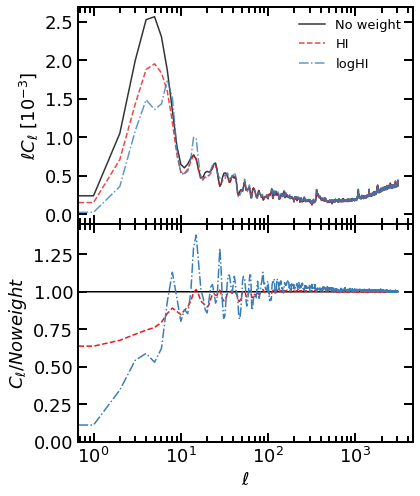

In [48]:
fg, ax = plt.subplots(nrows=2, figsize=(6, 8), sharex=True)
fg.subplots_adjust(hspace=0.0)

for n_i, cl_i in zip(['No weight', 'HI', 'logHI'],
                     [cl_null, cl_hi, cl_loghi]):
    
    
    ln = ax[0].plot(1000*cl_i['cl_gg']['l']*cl_i['cl_gg']['cl'], alpha=0.8, label=n_i)
    ax[1].plot(cl_i['cl_gg']['cl']/cl_null['cl_gg']['cl'], color=ln[0].get_color())
    
    
ax[0].legend()
ax[0].set(ylabel=r'$\ell C_{\ell}~[10^{-3}]$', xscale='log',)
ax[1].set(xlabel=r'$\ell$', ylim=(0.0, 1.45), ylabel='$C_{\ell} / Noweight$')

## Updated Galaxy Density Count

In [2]:
old = ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v2/nelg_features_bmzls_1024_old.fits')
new = ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v3/nelg_features_bmzls_1024.fits')

In [3]:
old.size, new.size

(1552540, 1552540)

In [4]:
np.array_equal(old['hpix'], new['hpix'])

True

In [5]:
old['label'], new['label']

(array([1.  , 1.  , 2.5 , ..., 4.25, 4.25, 2.25]),
 array([0., 0., 1., ..., 2., 3., 1.]))

In [6]:
frac = make_hp(1024, new['hpix'], new['fracgood'], True)
mask = np.isfinite(frac)
mask.sum()

1552540

In [21]:
old['features'][:, 0]-new['features'][:, 0]

array([0., 0., 0., ..., 0., 0., 0.])

In [24]:
syst = make_hp(1024, new['hpix'], new['features'][:, 0])[:, np.newaxis]
syst.shape

(12582912, 1)

In [25]:
nold = make_hp(1024, old['hpix'], old['label'])
nnew = make_hp(1024, new['hpix'], new['label'])

In [26]:
cl_old = get_cl(nold, frac, mask, systematics=syst, njack=0, cross_only=True)
cl_new = get_cl(nnew, frac, mask, systematics=syst, njack=0, cross_only=True)

Text(0.5, 0, '$\\ell$')

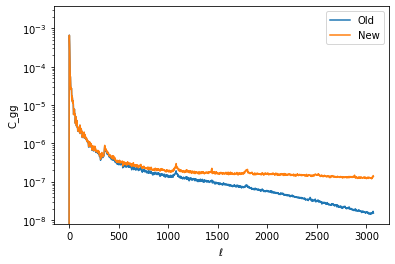

In [27]:
plt.plot(cl_old['cl_gg']['cl'], label='Old')
plt.plot(cl_new['cl_gg']['cl'], label='New')
plt.legend()
# plt.xscale('log')
plt.yscale('log') #symlog', linthreshy=1.0e-6)
plt.ylim(ymin=8.0e-9)
plt.ylabel('C_gg')
plt.xlabel(r'$\ell$')

In [36]:
from lssutils.utils import histogram_cell

Text(0.5, 0, '$\\ell$')

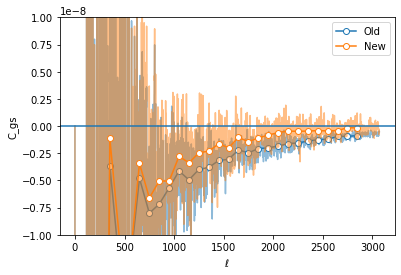

In [49]:
def plot(cl, **kw):
    
    lb = np.arange(0, 3000, 100)
    lb_, cl_ = histogram_cell(cl, bins=lb)
    
    al = kw.pop('alpha')
    lab = kw.pop('label')
    
    ln = plt.plot(cl, alpha=al, **kw)
    plt.plot(lb_, cl_, color=ln[0].get_color(), 
             label=lab, marker='o', mfc='w', **kw)

plot(cl_old['cl_sg'][0]['cl'], label='Old', alpha=0.5)
plot(cl_new['cl_sg'][0]['cl'], label='New', alpha=0.5)


plt.legend()

plt.axhline(0)
plt.ylim(-1.0e-8, 1.0e-8)
# plt.yscale('symlog', linthreshy=1.0e-9)
plt.ylabel('C_gs')
plt.xlabel(r'$\ell$')